notebook for the preprocessing stage

In [54]:
import pandas as pd
import json
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load("en_core_web_sm")


In [55]:
doc = r"https://docs.google.com/spreadsheets/d/19gFONrR0d4Ed57gGWtUqVHjjvw85WgysCh9ukhiTmBM/export?format=csv"

In [56]:
df = pd.read_csv(doc).drop(columns=['Topic_Category'])

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         243 non-null    object
 1   Title        244 non-null    object
 2   URL          244 non-null    object
 3   Publication  244 non-null    object
 4   Author       244 non-null    object
 5   Stance       244 non-null    object
 6   Content      244 non-null    object
dtypes: object(7)
memory usage: 13.5+ KB


In [58]:
def clean_text_spacy(text):
    if not text:
        return []
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

In [59]:
df = df.dropna(subset=["Stance", "Content", "URL"])
# Drop any nulls in essential fields

# Optional: deduplicate based on URL
df = df.drop_duplicates(subset=["URL"])

In [60]:
output = []
import uuid

for _, row in df.iterrows():
    item = {
        "id": str(uuid.uuid4()),  # add a random unique id,
        #"topic_id": int(float(row["Topic_Category"])) if pd.notna(row["Topic_Category"]) else -1,
        "stance": row["Stance"].strip().lower(),
        "title": row["Title"].strip().lower(),
        "title_tokens" : clean_text_spacy(row['Title']),
        "source": row["Publication"].strip().lower(),
        "author": row["Author"].strip().lower(),
        "url": row["URL"],
        "date": row["Date"],
        "text": row["Content"].strip().lower(),
        "tokens": clean_text_spacy(row["Content"]),
        "embedding": None
    }
    output.append(item)

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# metrics functions
def get_stance_distribution(df):
    return df["stance"].value_counts()

def get_token_lengths(df):
    return df["tokens"].apply(len)

def get_title_token_lengths(df):
    return df["title_tokens"].apply(len)

# dashboard function
def plot_full_dashboard(df):
    sns.set_theme(style="whitegrid")

    # calculate metrics
    stance_counts = get_stance_distribution(df)
    token_lengths = get_token_lengths(df)
    title_token_lengths = get_title_token_lengths(df)

    # set up plot grid
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle("Dataset Metrics Dashboard", fontsize=20)

    # stance distribution
    sns.barplot(x=stance_counts.index, y=stance_counts.values, ax=axs[0])
    axs[0].set_title("Stance Distribution", fontsize=14)
    axs[0].set_ylabel("Count")
    axs[0].set_xlabel("Stance")

    # article token lengths
    sns.histplot(token_lengths, bins=20, kde=True, ax=axs[1])
    axs[1].set_title("Article Token Lengths", fontsize=14)
    axs[1].set_xlabel("Number of Tokens")
    axs[1].set_ylabel("Number of Articles")

    # title token lengths
    sns.histplot(title_token_lengths, bins=15, kde=True, ax=axs[2])
    axs[2].set_title("Title Token Lengths", fontsize=14)
    axs[2].set_xlabel("Number of Tokens in Title")
    axs[2].set_ylabel("Number of Titles")

    plt.tight_layout(pad=2)

In [62]:
df = pd.DataFrame(output)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            244 non-null    object
 1   stance        244 non-null    object
 2   title         244 non-null    object
 3   title_tokens  244 non-null    object
 4   source        244 non-null    object
 5   author        244 non-null    object
 6   url           244 non-null    object
 7   date          243 non-null    object
 8   text          244 non-null    object
 9   tokens        244 non-null    object
 10  embedding     0 non-null      object
dtypes: object(11)
memory usage: 21.1+ KB


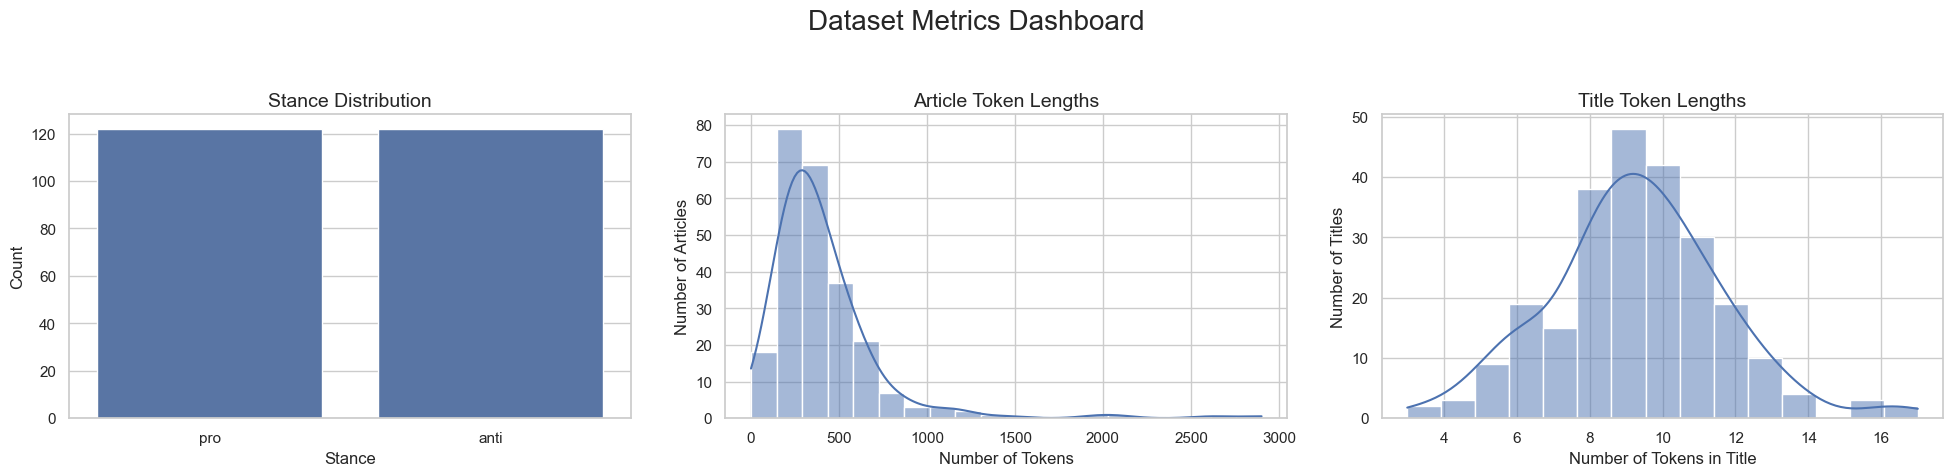

In [64]:
plot_full_dashboard(df)

In [65]:
df.head(5)

,id,stance,title,title_tokens,source,author,url,date,text,tokens,embedding
0,eda814f0-b7b2-43e3-8be9-6a7c170f19b4,pro,mapping attacks on lgbtq rights in u.s. state ...,"[mapping, attack, lgbtq, right, state, legisla...",aclu,none listed,https://www.aclu.org/legislative-attacks-on-lg...,4/11/2025,no text content,"[text, content]",None
1,e8ab96b3-eb08-41db-95ac-a9e098ec484e,pro,the human toll of trump's anti-trans crusade,"[human, toll, trump, anti, trans, crusade]",aclu,lisa francois,https://www.aclu.org/news/lgbtq-rights/the-hum...,4/3/25,president donald trump’s assault on transgende...,"[president, donald, trump, assault, transgende...",None
2,5ee886ac-3f21-42b5-b842-aeb2916552d6,pro,perkins et al. v. state (hb 121),"[perkin, et, al, state, hb]",aclu,none listed,https://www.aclu.org/cases/perkins-et-al-v-state,4/3/25,"hb 121, which took effect on march 27, 2025, i...","[hb, take, effect, march, draconian, law, sing...",None
3,3fa9bb9d-ce25-4325-b91f-acd8d8ff192a,anti,montana senate endorses bill tying bathrooms t...,"[montana, senate, endorse, bill, tie, bathroom...",kpax (local news),jonathon ambarian,https://www.kpax.com/news/montana-senate-endor...,2/11/2025,a bill that would require transgender people i...,"[bill, require, transgend, people, montana, us...",None
4,e53c9e0b-0b98-4098-b1a4-867f306bcda4,pro,library patrons sue greenville county over wid...,"[library, patron, sue, greenville, county, wid...",aclu,none listed,https://www.aclu.org/press-releases/library-pa...,3/26/25,"greenville, s.c. – local library patrons, with...","[greenville, local, library, patron, help, ame...",None


In [66]:
df.to_csv('pre-processed-articles.csv', index=False)